# Food Images Classification

## DS-telecom-14 - Applied Deep Learning with Python (2021-2022)
<blockquote> 
Alexandre PERBET<br>
Cyril NERIN<br>
Hugo RIALAN<br>
</blockquote>

<p><b>The objective of the project is to identify the name of a food recipe from a photo.</b></p> 
<p>For this, we use a transfer learning method on a pre-trained CNN model whose performance is evaluated with the "accuracy" metric.</p> 
<p>We use the Food-101 dataset available in Kaggle which contains 101000 tagged images of food which are distributed in 101 classes. (<a href= https://www.kaggle.com/kmader/food41>https://www.kaggle.com/kmader/food41</a>). </p>
<p>After testing on Kaggle with GPU several pre-trained models, we chose the one that gives the best accuracy value on the validation data.</p>
<p>After tuning the model, we will be able to complete the dataset of food images with photos from other sites (e.g. marmiton) or personal photos.</p>
<p>In a dedicated notebook, we analyze the results obtained by plotting the classification report and the confusion matrix and by visualizing some images of correctly recognized food and some images not recognized by the model. We try to understand why some images are misclassified.</p>
<p>We also plan to develop a <b>demo web-app</b> to test our best model on new images.
<p>Our project answers <b>two use cases</b>: the model could be used to make focused advertising (restaurant, pastry chef ... ) from the analysis of food images posted on social networks or it could be used in a dedicated application available on smartphone that would give the name and the recipe of a dish from a photo and its nutritional information.</p>

## Notebook settings

In [1]:
import os

Models = {}

# Run locally on the laptop or run on Kaggle to take advantage of the GPU
running_on_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') != 'Localhost'

if running_on_kaggle:
    print('Kaggle environment detected')
    data_dir = '/kaggle/input/food41/images/'
    result_dir = '/kaggle/working'
    Models["custom_model"] = "/kaggle/input/models/saved_models/custom_model_v2"
    Models["inceptionV3"] = "/kaggle/input/models/saved_models/inceptionV3_15epochs"
    Models["EfficientNetB0"] = "/kaggle/input/models/saved_models/EfficientNetB0_20epochs"
else:
    print('Running on localhost')
    data_dir = './dataset/food/images/'
    result_dir = 'result_files/'
    Models["custom_model"] = "./saved_models/custom_model_v2"
    Models["inceptionV3"] = "./saved_models/inceptionV3_15epochs"
    Models["EfficientNetB0"] = "./saved_models/EfficientNetB0_20epochs"

print("The models are: {}".format(Models))

Running on localhost
The models are: {'custom_model': './saved_models/custom_model_v2', 'inceptionV3': './saved_models/inceptionV3_15epochs', 'EfficientNetB0': './saved_models/EfficientNetB0_20epochs'}


## Libraries

In [2]:
import sys 
print("Python version: {}". format(sys.version))

import random

import IPython
from IPython import display
from IPython.display import Markdown, display
print("IPython version: {}". format(IPython.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp
from scipy import stats
print("SciPy version: {}". format(sp.__version__))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import sklearn
from sklearn.metrics import confusion_matrix, classification_report
print("sklearn version: {}". format(sklearn.__version__))

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import seaborn as sns
print("seaborn version : {}". format(sns.__version__))
sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("tensorflow version : {}". format(tf.__version__))

import imageio
print("imageio version : {}". format(imageio.__version__))
print("================================")

Python version: 3.9.2 (v3.9.2:1a79785e3e, Feb 19 2021, 09:06:10) 
[Clang 6.0 (clang-600.0.57)]
IPython version: 7.20.0
NumPy version: 1.21.5
SciPy version: 1.7.3
pandas version: 1.3.5
sklearn version: 1.0.2
matplotlib version: 3.5.1
seaborn version : 0.11.2
tensorflow version : 2.7.0
imageio version : 2.13.5


## Utility functions

We have developed utility functions in order to help the analysis of the model.

In [3]:
def get_result_pred(model, model_name, val_data, data_dir, img_height, img_width):
    """
    This function allows you to save the results of a model in a CSV file. 
    This avoids recalculating the predictions on the test data, which is a time consuming task. 
    """

    class_dict=val_data.class_indices
    labels= val_data.labels
    file_names= val_data.filenames 
    to_print = max(int(len(file_names) / 100), 10)
    
    new_dict = {}
    dict_result = {}
    dict_result["image"] = []
    dict_result["True_class"] = []
    dict_result["Predict_class"] = []
    for key in class_dict.keys():
        dict_result[key] = []
    dict_result["True_index"] = []
    dict_result["Predict_index"] = []
    dict_result["Result_OK"] = []
    
    
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}

    print("Processing in progress ", end="")
 
    for i, fichier in enumerate(file_names):
        if (i % to_print) == 0:
            print('.', end="")
        dict_result["image"].append(fichier)
        dict_result["True_index"].append(labels[i])  # labels are integer values
        dict_result["True_class"].append(new_dict[labels[i]])
        
        image_file = os.path.join(data_dir, fichier)
        img = tf.keras.utils.load_img(image_file, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = img_array / 255.
        img_array = tf.expand_dims(img_array, 0) # Create a batch    
        predictions = model.predict(img_array)
        score = predictions[0]
        
        for j, valeur in enumerate(score):
            dict_result[new_dict[j]].append(valeur)

        pred_index=np.argmax(score)
        dict_result["Predict_index"].append(pred_index)
        dict_result["Predict_class"].append(new_dict[pred_index])

        Result_OK = (pred_index == labels[i] )
        dict_result["Result_OK"].append(Result_OK)

    df_result = pd.DataFrame(dict_result)

    # Saving the dataframe to disk (csv format)
    csv_file_name = "result_{}.csv".format(model_name)
    result_file = os.path.join(result_dir, csv_file_name)
    df_result.to_csv(result_file, sep=';', decimal=',')

    return df_result

In [4]:
def print_info(df_result):
    """
    Displays useful data for the analysis of the model : 
        -  Nb of errors by classes
        -  Confusion Matrix
        -  Classification report
    """
        
    # Nb of errors by classes
    condition_1 = df_result["Result_OK"] == False
    df_erreurs = df_result[condition_1]
    df_nb_error_by_class = pd.DataFrame(df_erreurs["True_class"].value_counts())
    df_nb_error_by_class.sort_values(by="True_class", ascending=True, inplace=True)
    ax = df_nb_error_by_class.plot.barh(color="blue",
                                        figsize=(10, df_nb_error_by_class.shape[0] / 3),
                                        title="Errors by Class on Test Set",
                                        legend=None)
   
    # create a confusion matrix and a classification report
    df_classes = df_result[["True_class", "True_index"]].drop_duplicates()
    df_classes.sort_values(by="True_index", ascending=True, inplace=True)
    classes = df_classes["True_class"].values.tolist()
    indices = df_classes["True_index"].values.tolist()
    
    cm = confusion_matrix(df_result["True_index"], df_result["Predict_index"])
    clr = classification_report(df_result["True_index"], df_result["Predict_index"], target_names=classes)
    
    length=len(classes)

    plt.figure(figsize =(30,30))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='coolwarm', cbar=False)
    plt.xticks(np.arange(length)+.5, label = indices, rotation= 90)
    plt.yticks(np.arange(length)+.5, label = indices, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)

In [5]:
def plot_samples(df_result, custom_query="Result_OK == True"):
    """
    Displays images samples with True/Pred labels. 
    Data are taken from the dataframe created by the "get_result_pred" function. 
    A custom_query allows to select appropriate images for a further analysis. 
    """
    
    df_missclassified = df_result.query(custom_query).sample(n=9)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = plt.imread(data_dir + df_missclassified.iloc[i]['image'], format=(224,224))
        
        plt.imshow(img)
        title = 'True : ' + df_missclassified.iloc[i]['True_class'] + \
                '\n Predicted : ' + df_missclassified.iloc[i]['Predict_class']
        plt.title(title)
        plt.axis("off")
    
    plt.show()

# Inception V3

We decided to detail our analysis on the inceptionV3 model which is the one used in our demo application.

[https://paperswithcode.com/method/inception-v3](https://paperswithcode.com/method/inception-v3)

<img src="https://production-media.paperswithcode.com/methods/inceptionv3onc--oview_vjAbOfw.png">

InceptionV3 is a convolutional neural network. It has under than 25 millions parameters. We took the keras version trained on the  ImageNet database for this project.

In [6]:
batch_size = 32

img_height = 224
img_width = 224

Firstly, we used data augmentation techniques to artificially add data and avoid overfitting on train set :
- We **rescaled** the images
- We added **random rotations** with the parameter "rotation_range"
- "width_shift_range" and "height_shift_range" allows to **shift** the images on a horizontal and vertical way
- "shear_range" corresponds to a **Shear** angle Intensity between the old and the new image
- Finally, we added a **random zoom** and an **horizontal flip**

In [7]:
train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2)

test_data_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)

In [8]:
train_data = train_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = test_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


There are 1000 images per class in the dataset.

In [9]:
class_dict  = train_data.class_indices
class_names = []
for cat in class_dict.keys():
    class_names.append(cat)
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

There are recipes from all over the world.

In [10]:
inceptionV3 = keras.models.load_model(Models["inceptionV3"])

In [11]:
# compute or load predictions

try :
    df_inceptionV3 = pd.read_csv(result_dir + 'result_inceptionV3.csv', sep=";", index_col=0)
except:
    df_inceptionV3 = get_result_pred(inceptionV3, "inceptionV3", val_data, data_dir, img_height, img_width)

### Some well classified prediction samples

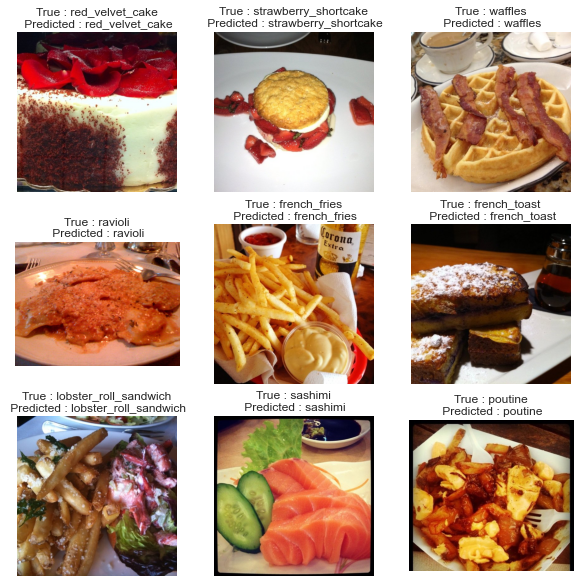

In [12]:
plot_samples(df_inceptionV3, "Result_OK == True")

### Some missclassified samples

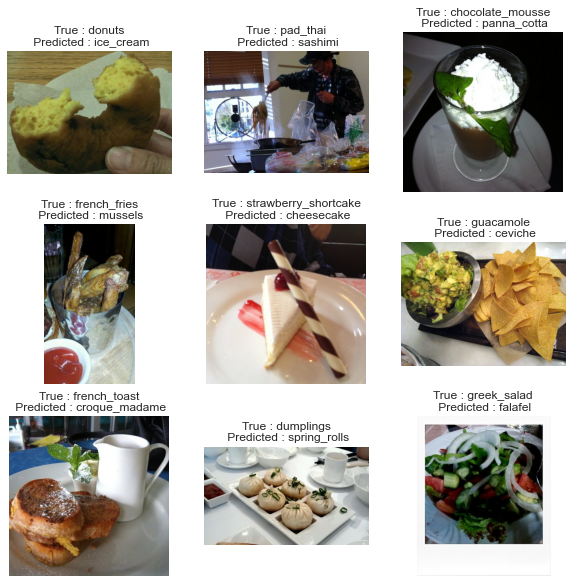

In [13]:
plot_samples(df_inceptionV3, "Result_OK == False")

We can see that there are all kinds of recipes and all kinds of images. Some recipes are difficult to recognize even for a human. 

This has the effect of slowing down the learning of our model but the fact of having very different images also has a great advantage. Let's go back to our original use case which was a mobile application that allows to recognize recipes either for blind people, or to have the nutritional qualities of the recipe, or other. The input data can then be very different, different shooting angles, different brightness, different resolution.

## A deeper analysis

In [14]:
nb_items_per_classes = np.unique(val_data.classes, return_counts=1)[1][0]
print('There are', nb_items_per_classes,'images per class in the test data.')

There are 200 images per class in the test data.


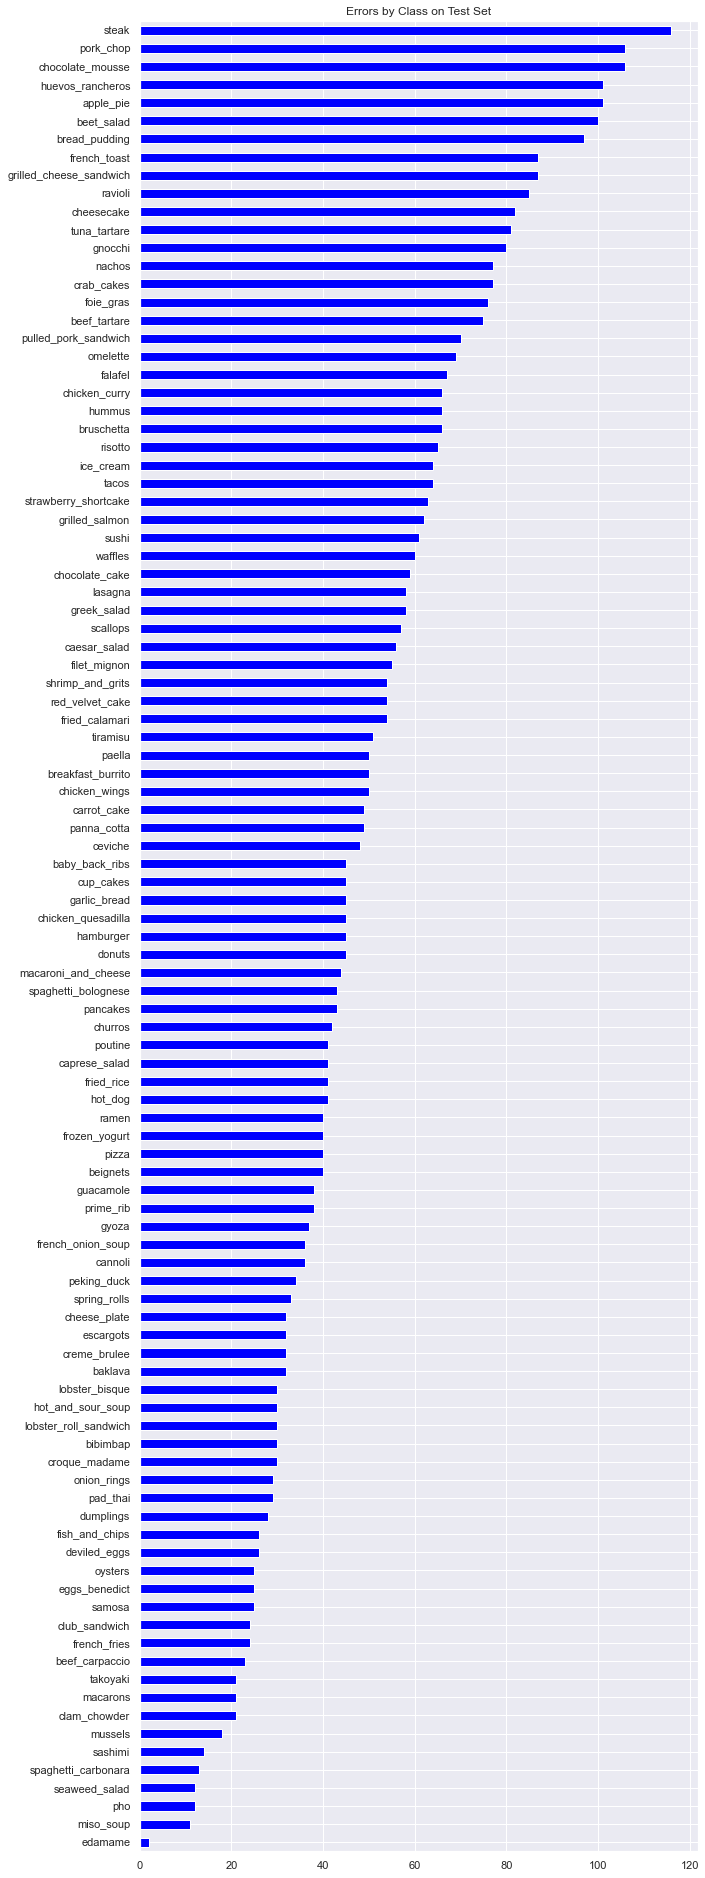

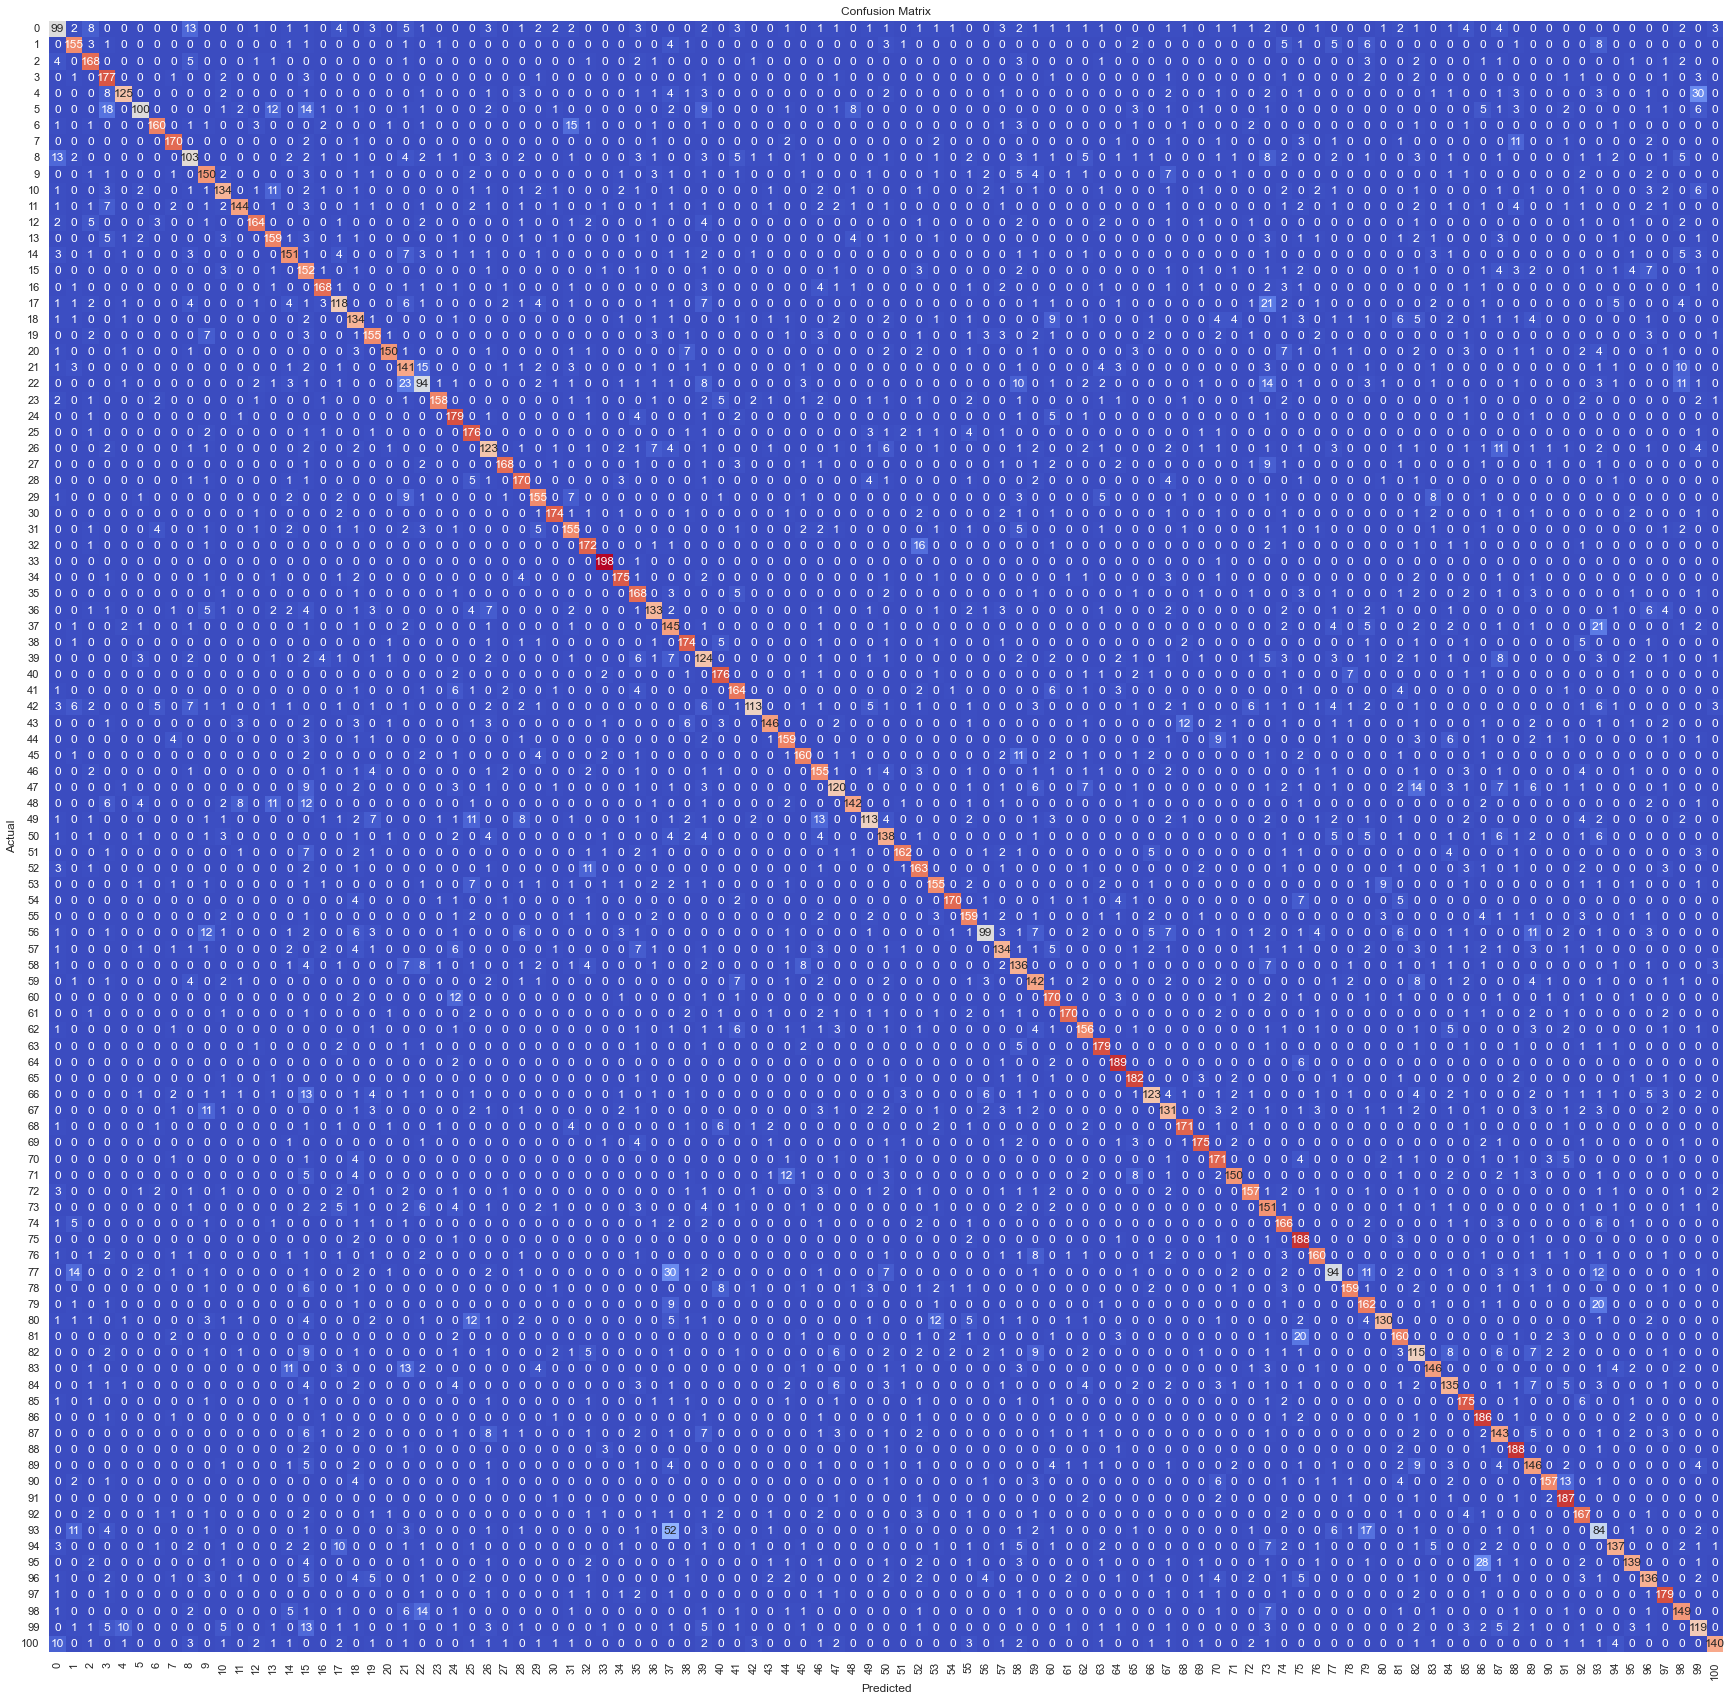

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.59      0.49      0.54       200
         baby_back_ribs       0.73      0.78      0.75       200
                baklava       0.77      0.84      0.81       200
         beef_carpaccio       0.70      0.89      0.78       200
           beef_tartare       0.85      0.62      0.72       200
             beet_salad       0.83      0.50      0.62       200
               beignets       0.89      0.80      0.84       200
               bibimbap       0.88      0.85      0.87       200
          bread_pudding       0.65      0.52      0.57       200
      breakfast_burrito       0.70      0.75      0.72       200
             bruschetta       0.75      0.67      0.71       200
           caesar_salad       0.88      0.72      0.79       200
                cannoli       0.92      0.82      0.87       200
          caprese_salad       0.76      0.

In [15]:
print_info(df_inceptionV3)

### Analysis focused on the most missclassified recipe

By looking at the first graph, we see that 'steak' is the class with the most misclassification. This class corresponds to the index : 

In [16]:
np.where( np.array(class_names)  == 'steak')[0][0]

93

Then, if we look at the confusion matrix at the line corresponding to this index, we note that the images that contain a steak are often predicted by images of class 37 which corresponds to: 

In [17]:
class_names[37]

'filet_mignon'

let's look at some pictures to understand why the model makes this mistake.

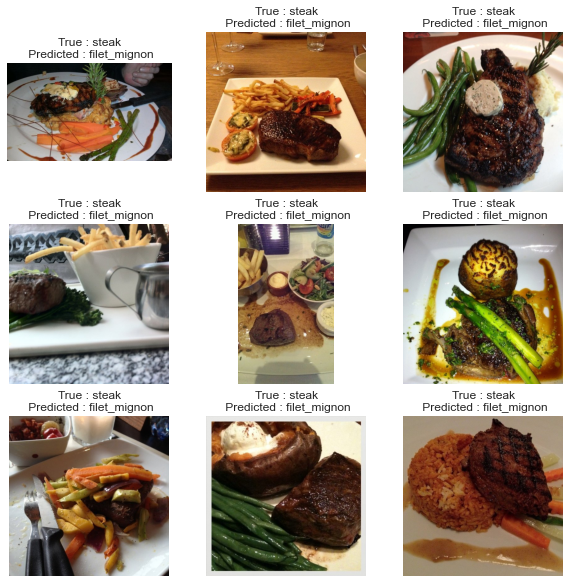

In [18]:
plot_samples(df_inceptionV3, custom_query="True_class == 'steak' & Result_OK == False & Predict_class == 'filet_mignon'")

All these steak images are classified as filet mignon. Let's see what the real filet mignon images are, so we can compare. 

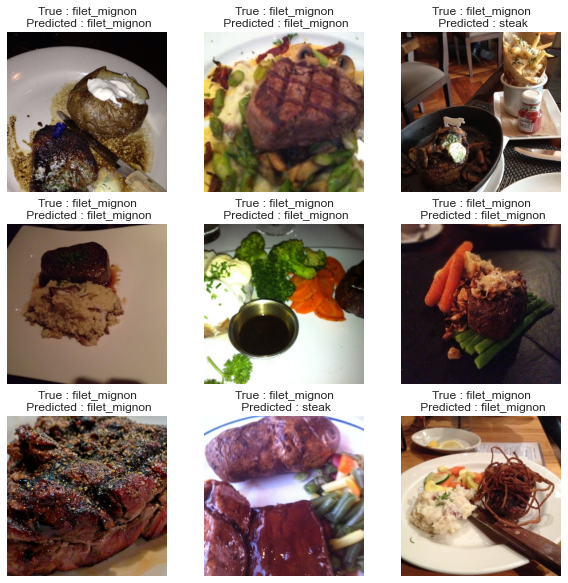

In [19]:
plot_samples(df_inceptionV3, custom_query="True_class == 'filet_mignon'")

Visually the recipes are very similar, this explains the results of the model on this recipe.

### Analysis focused on false predictions with the highest probability score

For a deeper analysis, we decided to visualize the missclassified images with a high predicition probability score.
For example, if a chocolate cake is predicted to be a steak with a 95% probability then it may be interesting to understand why by displaying these images. 

#### Extract food columns

In [20]:
colonnes = df_inceptionV3.columns
col_to_delete = ["image", "True_class", "Predict_class", "True_index", "Predict_index","Result_OK"]
food_classes = []
for col in colonnes:
    if col not in col_to_delete:
        food_classes.append(col)
print("food_classes={}".format(food_classes))

food_classes=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macaron

#### Add a column proba_max to the dataframe

In [21]:
df_inceptionV3["proba_max"] = df_inceptionV3[food_classes].max(axis=1)
print(df_inceptionV3["proba_max"])

0         9,904142e-05
1        9,9914305e-06
2         9,774402e-06
3        9,9082345e-06
4        9,7686325e-06
             ...      
20195      9,89447e-09
20196     9,783085e-07
20197     9,938118e-05
20198    9,8271244e-05
20199     9,854501e-11
Name: proba_max, Length: 20200, dtype: object


#### Store the best exemple of true image for each class

In [22]:
True_image = {}
for classe in food_classes:
    Condition = (df_inceptionV3["Result_OK"] == True) & \
                (df_inceptionV3["True_class"] == classe)
    df_image = df_inceptionV3[Condition].sort_values(by="proba_max", ascending=False).head(1)
    True_image[classe] = df_image["image"].values[0]
#print(True_image)

#### Find the greatest error by class

In [23]:
Error_class = {}
Error_image = {}
for classe in food_classes:
    Condition = (df_inceptionV3["Result_OK"] == False) & \
                (df_inceptionV3["True_class"] == classe)
    df_image = df_inceptionV3[Condition].sort_values(by="proba_max", ascending=False).head(1)
    Error_class[classe] = df_image["Predict_class"].values[0]
    Error_image[classe] = df_image["image"].values[0]
#print(Error_class)
#print(Error_image)

#### Plot the images

In [24]:
def plot_the_images(Image_dir, true_img_1, img_1_pred_as_img_2, true_img_2, class_img_1, class_img_2):
    fig = plt.figure(figsize=(14, 5))
    fig.suptitle("---------- {} ----------".format(class_img_1))
    plt.subplot(1,3,1)
    file_true_img_1 = os.path.join(Image_dir, true_img_1)
    image_1 = imageio.imread(file_true_img_1)
    ax1 = plt.imshow(image_1)
    plt.title("True {}".format(class_img_1))
    plt.axis("off")
    plt.subplot(1,3,2)
    file_img_1_pred_as_img_2 = os.path.join(Image_dir, img_1_pred_as_img_2)
    image_1_2 = imageio.imread(file_img_1_pred_as_img_2)
    ax2 = plt.imshow(image_1_2)
    plt.title("{} predicted as {}".format(class_img_1, class_img_2))
    plt.axis("off")
    plt.subplot(1,3,3)
    file_true_img_2 = os.path.join(Image_dir, true_img_2)
    image_2 = imageio.imread(file_true_img_2)
    ax1 = plt.imshow(image_2)
    plt.title("True {}".format(class_img_2))
    plt.axis("off")
    plt.show()

Here are the results : (We have displayed only 10 examples but it is of course possible to display more)

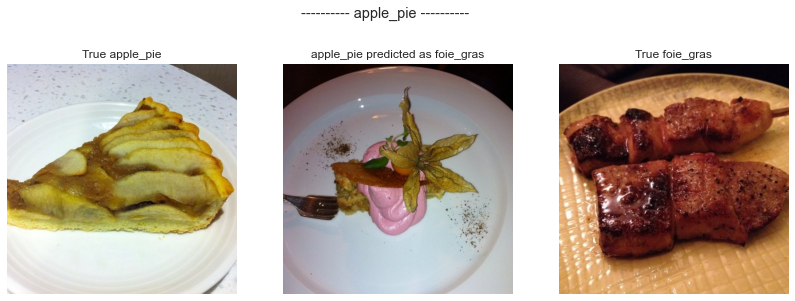

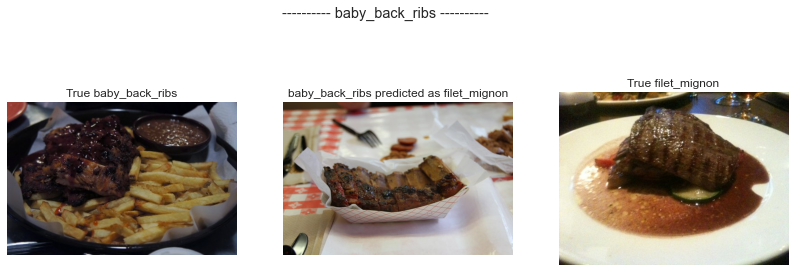

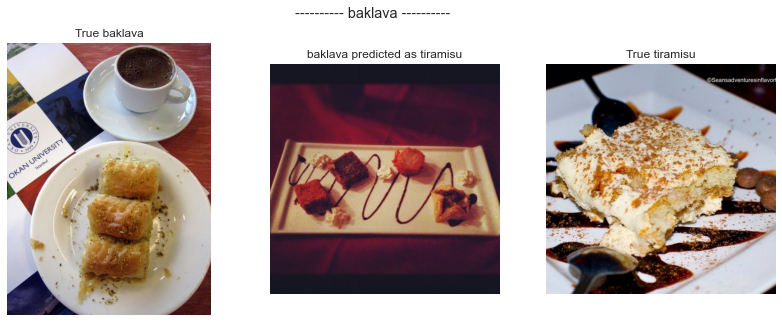

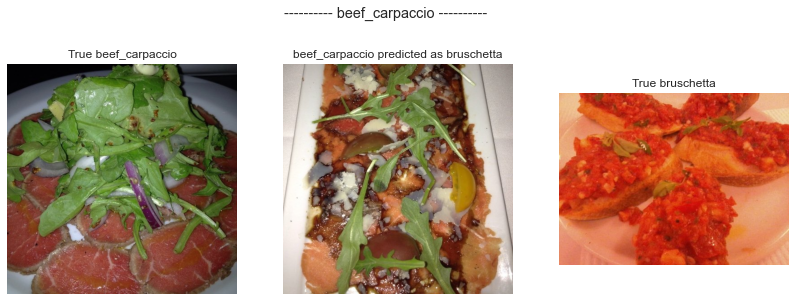

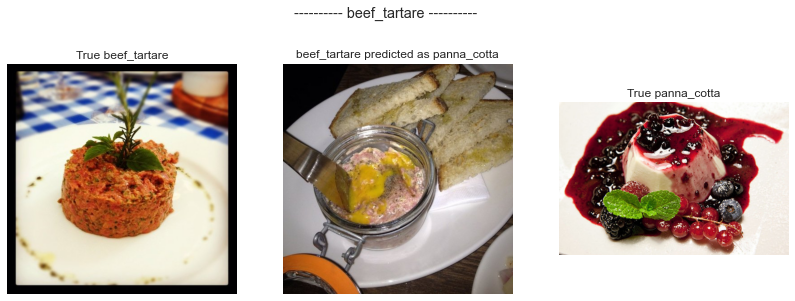

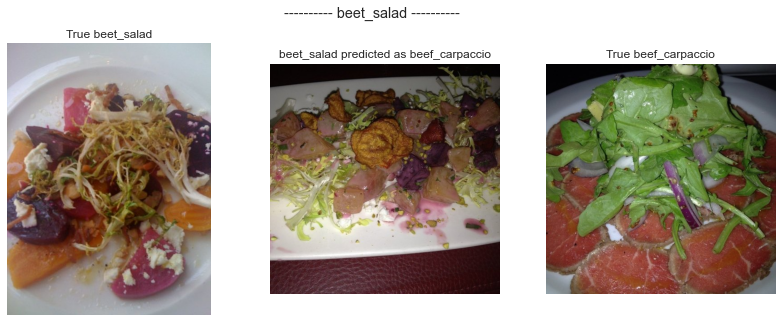

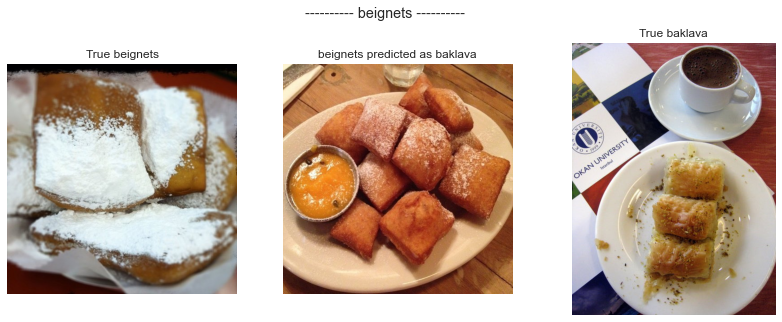

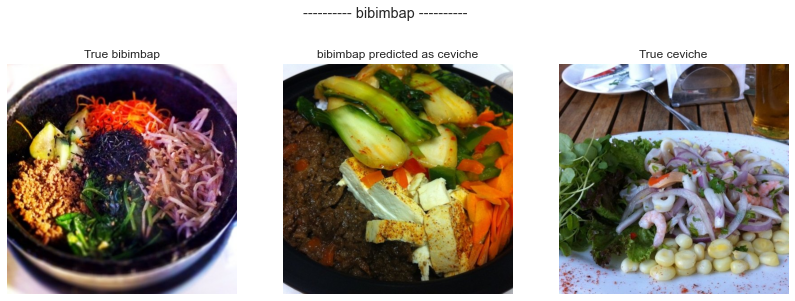

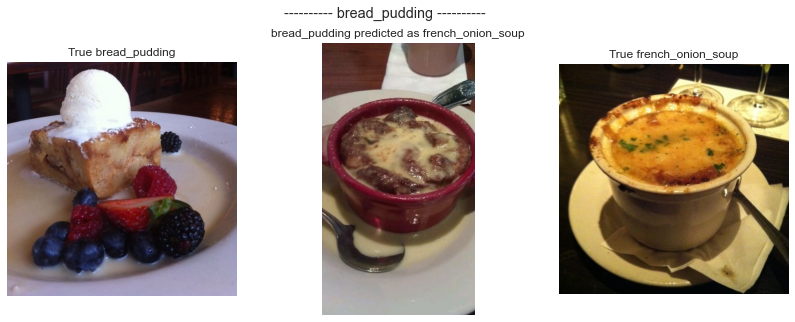

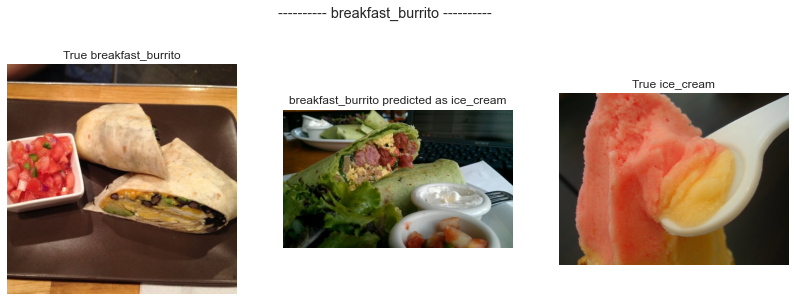

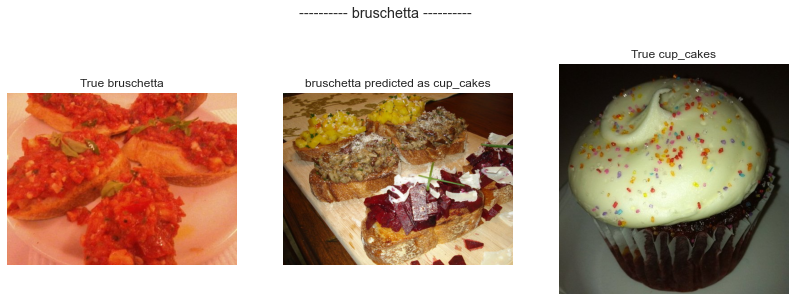

In [29]:
Image_dir = "./dataset/food/images"
nb_samples_to_print = 10

cnt = 0
for class_food in food_classes:
    print("")
    plot_the_images(Image_dir, 
                    True_image[class_food], 
                    Error_image[class_food],
                    True_image[Error_class[class_food]],
                    class_food,
                    Error_class[class_food])
    print("")
    cnt += 1
    if cnt > nb_samples_to_print:
        break

We can summarize the model's difficulty in predicting some recipes as: 

- Some recipes are extremely similar visually (e.g. steak, filet mignon)
- Some recipes can be presented very differently. for example the French apple pie is very different from the American one. Even in France there are different ways of presenting an apple pie, as a slice or as a whole pie, with visible or hidden apples.
- The photos in the database are very diverse, which is a strength if we plan to deploy the model in production. We imagine that some photos are taken at home, others at the restaurant, some are perfectly framed, others very badly. 